In [1]:
from chofer_tda_datasets import SciNe01EEGRawSignal
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
from collections import defaultdict


class train_env:
    train_size= 0.9

def svm_linear_standard_scaled_pca_c_optimized(pca_n_components):
    grid = {'C': [0.1, 1, 10, 100]}
    clf = GridSearchCV(cv=3, 
                       estimator=LinearSVC(),
                       param_grid=grid, 
                       n_jobs=10
                       )
    scaler = StandardScaler()
    pca = PCA(pca_n_components)
    return Pipeline([('scaler', scaler), ('pca', pca), ('clf', clf)])

/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = SciNe01EEGRawSignal(data_root_folder_path='/scratch1/chofer/jmlr2018_data/')
sensor_indices = [str(i) for i in dataset.sensor_configurations['low_resolution_whole_head']]
dataset.data_transforms = [
                           lambda x: [x[i].value for i in sensor_indices], 
                           lambda x: np.concatenate(x, axis=0)
                           ]

dataset.target_transforms = [lambda x: int(x)]

In [6]:
def experiment_pca_linear_svm():
    X, y = [], []
    print('loading data ... ')
    for i, (x_i, y_i) in enumerate(dataset):
        X.append(x_i)
        y.append(y_i)
        print(i, end='\r')    
    print('')
    
    X = np.stack(X, axis=0)
    y = np.array(y)
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)

    
    stats_of_runs = []   

    for fold_i, (train_i, test_i) in enumerate(splitter.split(y, y)):
        print(fold_i, end='\r')
        stats = defaultdict(list)
        stats_of_runs.append(stats)

        classifier = svm_linear_standard_scaled_pca_c_optimized(250)


        X_train = X[train_i, :]
        X_test  = X[test_i, :]   

        y_train = y[train_i]
        y_test = y[test_i]

#         X_train = pca.transform(X_train)
#         X_test = pca.transform(X_test)    

        classifier.fit(X_train, y_train) 

        y_pred = classifier.predict(X_test)
        y_true = y[test_i]
        
        stats['y_pred'] = y_pred
        stats['y_true'] = y_true
        
        stats['cls'] = classifier
        
        stats['accuracy'] = accuracy_score(y_pred, y_true)

    return dict(stats_of_runs)


In [7]:
stats_of_runs = experiment_pca_linear_svm()

loading data ... 
31499


NameError: name 'pca' is not defined

In [11]:
with open('./scitrecs_eeg_linear_svm_no_feature_map.res.pickle', 'bw') as f:
    pickle.dump(stats_of_runs, f)

In [2]:
with open('./scitrecs_eeg_linear_svm_no_feature_map.res.pickle', 'br') as f:
    stats_of_runs = pickle.load(f)

In [16]:
print(np.mean([stats['accuracy'] for stats in stats_of_runs]))
print(np.std([stats['accuracy'] for stats in stats_of_runs]))
[stats['accuracy'] for stats in stats_of_runs]

0.3025714285714286
0.009482928130378614


[0.30444444444444446,
 0.29428571428571426,
 0.2980952380952381,
 0.3215873015873016,
 0.2974603174603175,
 0.31174603174603177,
 0.3057142857142857,
 0.31015873015873013,
 0.2926984126984127,
 0.2895238095238095]

In [10]:
pca = stats_of_runs[0]['cls'].named_steps['pca']
pca.explained_variance_

array([3.10282520e+03, 6.55099243e+02, 2.07885391e+02, 1.84420227e+02,
       1.62664078e+02, 1.19688171e+02, 9.82014771e+01, 7.95261993e+01,
       6.49339676e+01, 6.13269081e+01, 5.82398491e+01, 5.05818901e+01,
       3.94886932e+01, 2.97255802e+01, 2.31220150e+01, 2.17021217e+01,
       1.68323402e+01, 8.68282604e+00, 8.16550255e+00, 6.84132528e+00,
       7.08792508e-02, 5.73409200e-02, 1.60381105e-02, 8.90620053e-03,
       6.59557479e-03, 6.29472779e-03, 5.94128249e-03, 5.76087460e-03,
       4.98256320e-03, 3.76743195e-03, 3.32595850e-03, 3.22502758e-03,
       2.22978694e-03, 2.00133328e-03, 1.73001003e-03, 1.50749518e-03,
       1.28525717e-03, 1.17358810e-03, 1.01684104e-03, 9.24938417e-04,
       8.89731280e-04, 8.33277532e-04, 7.91701255e-04, 7.25527818e-04,
       6.85579143e-04, 6.38582220e-04, 5.85293863e-04, 5.42381371e-04,
       5.29573124e-04, 5.26049116e-04, 5.10486134e-04, 5.02557959e-04,
       4.57578019e-04, 4.42398828e-04, 4.36235918e-04, 3.91904294e-04,
      

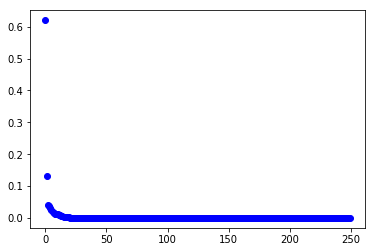

In [11]:
stats = stats_of_runs[0]
cls = stats['cls']
pca = cls.steps[1][1]
pca.explained_variance_ratio_

plt.plot(pca.explained_variance_ratio_, 'bo')

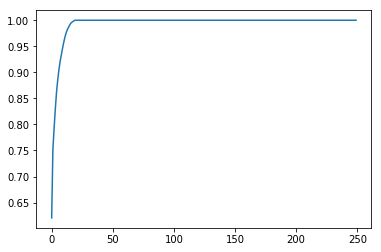

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))